In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
EPOCH = 10
LR = 0.01
BATCH_SIZE = 64
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=32)
test_set = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=32)

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2,),                      
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),)
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2), 
            nn.ReLU(), 
            nn.MaxPool2d(2),)
        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    
net = CNN()

In [4]:
def test_process(net, device, epoch):
    net.to(device)
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            total += labels.size(0)
            outputs = net(inputs.to(device)).cpu()
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / total
    print('Epoch: ', epoch+1, '| test accuracy: %.2f %%' % (accuracy * 100))

def train_process(net, device):
    losses = []
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=LR)
    for epoch in range(EPOCH):
        running_loss = 0.0
        for t, (inputs, labels) in enumerate(train_loader):
            net.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            
            losses.append(loss.cpu().item())
            running_loss += loss.cpu().item()
            if t % 200 == 199:
                print('Epoch: ', epoch+1, '| step: ', t+1, '| avg train loss: %.4f' % (running_loss / 200))
                running_loss = 0.0
        test_process(net, device, epoch)
        
    return losses

In [5]:
losses = train_process(net, DEVICE)

Epoch:  1 | step:  200 | avg train loss: 0.2909
Epoch:  1 | step:  400 | avg train loss: 0.1015
Epoch:  1 | step:  600 | avg train loss: 0.0828
Epoch:  1 | step:  800 | avg train loss: 0.0741
Epoch:  1 | test accuracy: 97.79 %
Epoch:  2 | step:  200 | avg train loss: 0.0584
Epoch:  2 | step:  400 | avg train loss: 0.0702
Epoch:  2 | step:  600 | avg train loss: 0.0575
Epoch:  2 | step:  800 | avg train loss: 0.0651
Epoch:  2 | test accuracy: 96.95 %
Epoch:  3 | step:  200 | avg train loss: 0.0499
Epoch:  3 | step:  400 | avg train loss: 0.0603
Epoch:  3 | step:  600 | avg train loss: 0.0558
Epoch:  3 | step:  800 | avg train loss: 0.0619
Epoch:  3 | test accuracy: 98.54 %
Epoch:  4 | step:  200 | avg train loss: 0.0511
Epoch:  4 | step:  400 | avg train loss: 0.0506
Epoch:  4 | step:  600 | avg train loss: 0.0530
Epoch:  4 | step:  800 | avg train loss: 0.0554
Epoch:  4 | test accuracy: 98.27 %
Epoch:  5 | step:  200 | avg train loss: 0.0464
Epoch:  5 | step:  400 | avg train loss: 0.0

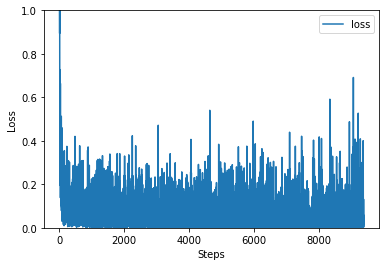

In [6]:
plt.plot(losses, label='loss')
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 1))
plt.show()